# Model Training: Forwards - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [16]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

In [37]:
forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 41 or more games played
forwards_41GP = forwards[(forwards['GP'] >= 41)].copy()
test_train_data = forwards_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

X = test_train_data[numerical_features]

y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0004995167175455405


In [38]:
# Step 2 & 3: Access the trained XGBRegressor model and get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
features = numerical_features  # This should be the list of features used to train the model

# Step 4: Map feature importances to feature names
importance_dict = dict(zip(features, feature_importances))

# Sort the features by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

# # If you have a large number of features and only want to see the top ones, you can slice the list
# print("Top 10 most important features:")
# for feature, importance in sorted_importances[:10]:
#     print(f"{feature}: {importance}")

OFF. ZONE FACEOFFS/GP: 0.21056853234767914
XGF/GP: 0.12767967581748962
CF/GP: 0.07666323333978653
TOI/GP: 0.04074257239699364
FF/GP: 0.021443165838718414
HDCF/GP: 0.016219064593315125
HITS TAKEN/60: 0.011731017380952835
TOTAL POINTS/GP: 0.010984317399561405
LDCF/GP: 0.01037574838846922
SHOTS BLOCKED/60: 0.009790481999516487
SHOTS/GP: 0.008933610282838345
DEF. ZONE FACEOFFS/GP: 0.00841307919472456
GIVEAWAYS/GP: 0.008318557403981686
TOTAL PENALTIES/60: 0.00746873440220952
FACEOFFS WON/GP: 0.007355302106589079
FA/60: 0.006942395586520433
FACEOFFS WON/60: 0.006595951039344072
DEF. ZONE FACEOFFS/60: 0.00626941304653883
PENALTIES DRAWN/60: 0.006258511915802956
IHDCF/60: 0.006200728937983513
SHOTS BLOCKED/GP: 0.00600676704198122
MINOR/GP: 0.005895438604056835
NEU. ZONE FACEOFFS/GP: 0.005836053751409054
FA/GP: 0.0057764495722949505
IFF/GP: 0.005739343352615833
DEF. ZONE STARTS/GP: 0.005709472578018904
FACEOFFS LOST/GP: 0.0055669997818768024
PIM/GP: 0.005525199230760336
SF/GP: 0.005441583693027

In [39]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [40]:
# Create a feature column in Centers for the predicted salary
forwards['PRED_SALARY_PERCENTAGE'] = pipeline.predict(forwards)

# Create a column for the actual predicted salary
forwards['PRED_AAV'] = forwards['PRED_SALARY_PERCENTAGE'] * forwards['SALARY CAP']
forwards['PRED_AAV'] = forwards['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
forwards['DIFF'] = forwards['PRED_AAV'] - forwards['AAV']

# Convert to dollars
forwards['PRED_AAV'] = convert_to_dollars(forwards, 'PRED_AAV')
forwards['AAV'] = convert_to_dollars(forwards, 'AAV')
forwards['DIFF'] = convert_to_dollars(forwards, 'DIFF')

In [41]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = forwards.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON'] + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
952,alex ovechkin,2009-10,"$9,538,462.00","$9,495,135.00","$-43,327.00",0.167168
424,alex ovechkin,2008-09,"$9,538,462.00","$9,316,014.00","$-222,448.00",0.164304
2812,alex ovechkin,2012-13,"$9,538,462.00","$9,255,127.00","$-283,335.00",0.154252
1454,sidney crosby,2009-10,"$8,700,000.00","$8,446,364.00","$-253,636.00",0.148704
9143,connor mcdavid,2020-21,"$12,500,000.00","$12,078,483.00","$-421,517.00",0.148202
1141,evgeni malkin,2009-10,"$8,700,000.00","$8,405,660.00","$-294,340.00",0.147987
41,brad richards,2007-08,"$7,800,000.00","$7,377,068.00","$-422,932.00",0.146661
881,sidney crosby,2008-09,"$8,700,000.00","$8,281,696.00","$-418,304.00",0.146062
11910,nathan mackinnon,2023-24,"$12,600,000.00","$12,163,694.00","$-436,306.00",0.145673
7617,connor mcdavid,2018-19,"$12,500,000.00","$11,568,188.00","$-931,812.00",0.145512


In [42]:
# Display all seasons for Connor McDavid
connor_mcdavid = forwards[forwards['PLAYER'] == 'connor mcdavid']
connor_mcdavid[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
5276,connor mcdavid,2015-16,"$3,775,000.00","$1,655,775.00","$-2,119,225.00",0.023190
6071,connor mcdavid,2016-17,"$3,775,000.00","$6,268,108.00","$2,493,108.00",0.085864
6841,connor mcdavid,2017-18,"$3,775,000.00","$2,026,585.00","$-1,748,415.00",0.027021
7617,connor mcdavid,2018-19,"$12,500,000.00","$11,568,188.00","$-931,812.00",0.145512
8398,connor mcdavid,2019-20,"$12,500,000.00","$11,366,314.00","$-1,133,686.00",0.139464
9143,connor mcdavid,2020-21,"$12,500,000.00","$12,078,483.00","$-421,517.00",0.148202
9952,connor mcdavid,2021-22,"$12,500,000.00","$10,104,607.00","$-2,395,393.00",0.123983
10786,connor mcdavid,2022-23,"$12,500,000.00","$11,820,339.00","$-679,661.00",0.143277
11570,connor mcdavid,2023-24,"$12,500,000.00","$10,014,237.00","$-2,485,763.00",0.119931


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Forwards')

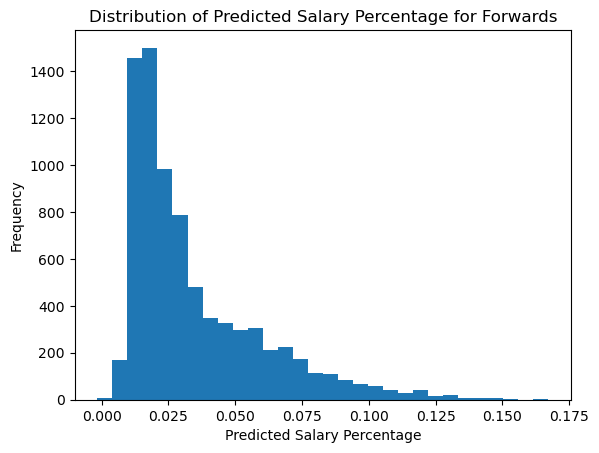

In [43]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(forwards['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Forwards')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Forwards')

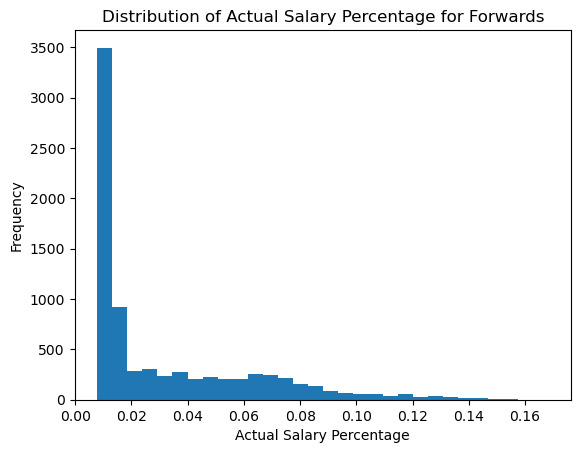

In [44]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(forwards['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Forwards')

In [45]:
# Filter players with over 41 GP
filtered_data = forwards[(forwards['GP'] > 60) & (forwards['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12045,"mtl, wpg",sean monahan,2023-24,"$2,000,000.00","$5,603,712.00","$3,603,712.00",0.067110,3603712.0
11539,"buf, col",casey mittelstadt,2023-24,"$2,500,000.00","$5,978,924.00","$3,478,924.00",0.071604,3478924.0
11701,bos,james van riemsdyk,2023-24,"$1,000,000.00","$3,933,149.00","$2,933,149.00",0.047104,2933149.0
11851,car,martin necas,2023-24,"$3,000,000.00","$5,338,794.00","$2,338,794.00",0.063938,2338794.0
12070,chi,taylor raddysh,2023-24,"$758,333.00","$3,014,074.00","$2,255,741.00",0.036097,2255741.0
11917,ari,nick bjugstad,2023-24,"$2,100,000.00","$4,341,930.00","$2,241,930.00",0.051999,2241930.0
11754,col,jonathan drouin,2023-24,"$825,000.00","$3,055,158.00","$2,230,158.00",0.036589,2230158.0
12133,dal,wyatt johnston,2023-24,"$1,000,417.00","$2,943,307.00","$1,942,890.00",0.035249,1942890.0
11975,chi,philipp kurashev,2023-24,"$2,250,000.00","$4,151,742.00","$1,901,742.00",0.049721,1901742.0
11541,vgk,chandler stephenson,2023-24,"$2,750,000.00","$4,542,377.00","$1,792,377.00",0.054400,1792377.0


In [46]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12005,col,ross colton,2023-24,"$4,000,000.00","$2,828,800.00","$-1,171,200.00",0.033878,-1171200.0
11723,n.j,jesper bratt,2023-24,"$7,875,000.00","$6,688,255.00","$-1,186,745.00",0.080099,-1186745.0
12096,tor,tyler bertuzzi,2023-24,"$5,500,000.00","$4,313,073.00","$-1,186,927.00",0.051654,-1186927.0
11721,buf,jeff skinner,2023-24,"$9,000,000.00","$7,746,545.00","$-1,253,455.00",0.092773,-1253455.0
11423,fla,aleksander barkov,2023-24,"$10,000,000.00","$8,653,707.00","$-1,346,293.00",0.103637,-1346293.0
11762,stl,jordan kyrou,2023-24,"$8,125,000.00","$6,762,612.00","$-1,362,388.00",0.080989,-1362388.0
12122,"fla, ott",vladimir tarasenko,2023-24,"$5,000,000.00","$3,598,053.00","$-1,401,947.00",0.043090,-1401947.0
11425,det,alex debrincat,2023-24,"$7,875,000.00","$6,467,512.00","$-1,407,488.00",0.077455,-1407488.0
11574,van,conor garland,2023-24,"$4,950,000.00","$3,526,807.00","$-1,423,193.00",0.042237,-1423193.0
11725,car,jesperi kotkaniemi,2023-24,"$4,820,000.00","$3,363,977.00","$-1,456,023.00",0.040287,-1456023.0


In [47]:
filtered_data[filtered_data['PLAYER'] == 'leon draisaitl'][display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
11810,leon draisaitl,2023-24,"$8,500,000.00","$8,808,808.00","$308,808.00",0.105495


In [48]:
predictions = pd.DataFrame(forwards[['PLAYER', 'SEASON', 'TOI/GP', 'PRED_SALARY_PERCENTAGE']])

# Save predictions to disk
save_dir = '../../Data/Warehouse/Predictions/' 
filename = 'forwards_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=False)